# 4. Other - Figures logit-logit

In [1]:
#from data_generation import *
from binnings import *
import matplotlib.pyplot as plt
import numpy as np
#from calibration_functions import *
#from calibration_function_derivates import *
import pandas as pd
import os
import pickle

In [1]:
from scipy.stats import beta

### Beta Distribution

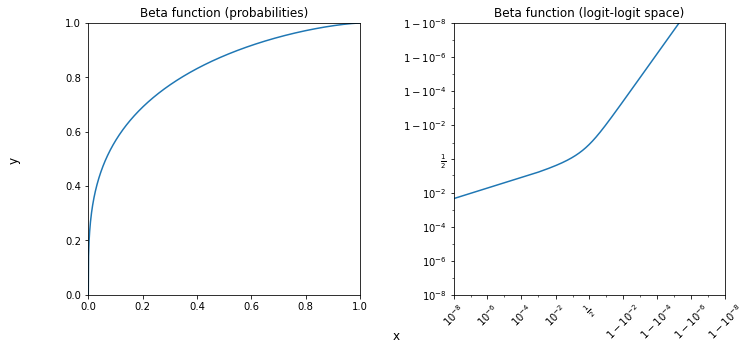

In [158]:
bd = beta(0.3, 1.4)
eps = 1e-8

fig, ax = plt.subplots(figsize=(12,5), nrows=1, ncols=2)

xrange = np.linspace(0, 1, 1000)
ax[0].plot(xrange, bd.cdf(xrange))
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_aspect("equal")
ax[0].set_title("Beta function (probabilities)")

xrange = np.linspace(eps, 1-eps, 1000)
ax[1].plot(xrange, bd.cdf(xrange))
ax[1].set_xlim([eps, 1-eps])
ax[1].set_ylim([eps, 1-eps])
ax[1].set_aspect("equal")
ax[1].set_xscale("logit")
ax[1].set_yscale("logit")

ax[1].set_title("Beta function (logit-logit space)")
fig.text(0.5, 0.0, "x", fontsize=12, ha='center')
fig.text(0.05, 0.5, "y", fontsize=12, va='center', rotation='vertical')
plt.xticks(rotation = 45)

plt.savefig(f"fig/beta_logit.pdf", dpi=250, bbox_inches="tight")

In [82]:
dict_cgt = {"resnet110": {}, "wide32": {}, "densenet40": {}}
keys = ["c_slope_1", "c_flat", "c_isotonic", "c_sweep"]

path_gt = "cgt_1m_log/"
files = os.listdir(path_gt)



for i, file in enumerate(files):
    print(file)
    
    pieces = file.split("_tag_")
    parts = pieces[0].split("_")
    data_name = parts[2]
    tag_name = pieces[1].split("_")[0]
    
    with open(os.path.join(path_gt, file), "rb") as f:
        logits_2m, probs_2m, c_s = pickle.load(f)
    #plt.hist(logits_2m[:100000], bins=100)
    #plt.show()
    dict_cgt[data_name][tag_name] = [c_s, probs_2m, logits_2m]
    

cgt_1m_densenet40_s7_tag_1vsRest1_with_c.p
cgt_1m_densenet40_s7_tag_1vsRest3_with_c.p
cgt_1m_densenet40_s7_tag_1vsRest5_with_c.p
cgt_1m_densenet40_s7_tag_confidence_with_c.p
cgt_1m_resnet110_s7_tag_1vsRest1_with_c.p
cgt_1m_resnet110_s7_tag_1vsRest3_with_c.p
cgt_1m_resnet110_s7_tag_1vsRest5_with_c.p
cgt_1m_resnet110_s7_tag_confidence_with_c.p
cgt_1m_wide32_s7_tag_1vsRest1_with_c.p
cgt_1m_wide32_s7_tag_1vsRest3_with_c.p
cgt_1m_wide32_s7_tag_1vsRest5_with_c.p
cgt_1m_wide32_s7_tag_confidence_with_c.p


In [159]:
PATH_PROBS = "probs_1m_cgt"

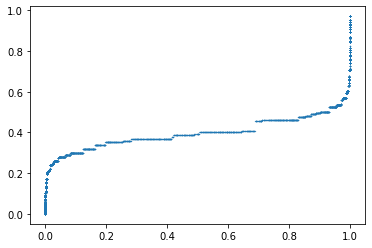

In [226]:
data_name = "resnet110"
tag_name = "1vsRest3"
cal_meth = "TempS"

file = "probs_1m_%s_%s_s7_tag_%s_with_c.p" % (cal_meth, data_name, tag_name)

with open(os.path.join(PATH_PROBS, file), "rb") as f:

    _, Y_2m = pickle.load(f)

plt.scatter(dict_cgt[data_name][tag_name][1][:100000], dict_cgt[data_name][tag_name][0]["c_isotonic"][:100000], s=0.05)

In [227]:
p = dict_cgt[data_name][tag_name][1][:10000]
y = Y_2m[:10000]
c = dict_cgt[data_name][tag_name][0]["c_isotonic"][:10000]

In [228]:
df2 = pd.DataFrame(np.array([p, c]).T).sort_values(by=0)

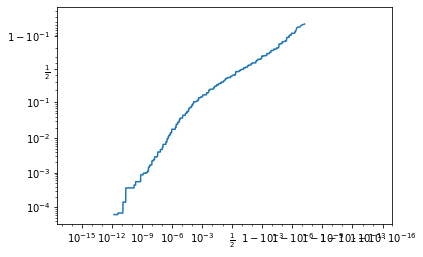

In [229]:
plt.plot(df2.iloc[:, 0], df2.iloc[:, 1])
plt.xscale("logit")
plt.yscale("logit")

### Figure with calibrated functions

In [171]:
from betacal import BetaCalibration
from cal_methods_slim import TemperatureScaling
from piecewise_linear import Piecewise_NN4, Piecewise_NN6

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [230]:
def logit(x):
    return np.log(x/(1-x))

def clip_logit(x, eps = 1e-16):
    x = np.array(x, dtype = np.float64)
    x_clip = np.clip(x, eps, 1-eps)
    return logit(x_clip)
    
def logit_to_scale(x, eps = 1e-16):
    l_max = logit(1-eps)
    x = np.array(x, dtype = np.float64)
    x_clip = np.clip(x, eps, 1-eps)
    return (logit(x_clip) + l_max)/(2*l_max)

In [288]:
bc = BetaCalibration(parameters="abm")
p = np.array(p, dtype=np.float64)

bc.fit(p.reshape(-1, 1), y)
c_hat_bc = bc.predict(p.reshape(-1, 1))

In [275]:
TempS = TemperatureScaling()
p = np.array(p, dtype=np.float64)
TempS.fit((clip_logit([1-p, p])/2).T, y)
c_hat_temp = TempS.predict((clip_logit([1-p, p])/2).T)[:, 1]

Cal. temperature is 7.7415416605536285


In [237]:
pw6 = Piecewise_NN6(k=11, lr=0.01, max_epochs=500, random_state = 5, equal_size = True, monotonic = False, logit_scale = True, logistic_out = True, use_ce_loss = True)
h = pw6.fit(np.array(p, dtype=np.float64), y, verbose=True, batch_size=512)
last_epoch = len(h.history['loss'])
print(last_epoch)

Using equal size with Borders: [-36.48071292754638, -25.16530042476803, -22.912122766656164, -21.443233985537926, -20.217288861981164, -19.118639001588203, -17.97946221930905, -16.66947598927537, -15.090663892896677, -12.726697592553563, -8.696594499814484, 1.7644464545863874, 36.7368005696771]
Epoch 1/500
10000/10000 [==============================] - 3s 278us/step - loss: 0.2856
Epoch 2/500
10000/10000 [==============================] - 0s 19us/step - loss: 0.2717
Epoch 3/500
10000/10000 [==============================] - 0s 12us/step - loss: 0.2589
Epoch 4/500
10000/10000 [==============================] - 0s 13us/step - loss: 0.2472
Epoch 5/500
10000/10000 [==============================] - 0s 11us/step - loss: 0.2365
Epoch 6/500
10000/10000 [==============================] - 0s 13us/step - loss: 0.2271: 0s - loss: 0.22
Epoch 7/500
10000/10000 [==============================] - 0s 13us/step - loss: 0.2181
Epoch 8/500
10000/10000 [==============================] - 0s 12us/step - los

10000/10000 [==============================] - 0s 9us/step - loss: 0.1180
Epoch 182/500
10000/10000 [==============================] - 0s 8us/step - loss: 0.1180
Epoch 183/500
10000/10000 [==============================] - 0s 10us/step - loss: 0.1179
Epoch 184/500
10000/10000 [==============================] - 0s 10us/step - loss: 0.1179
Epoch 185/500
10000/10000 [==============================] - 0s 10us/step - loss: 0.1179
Epoch 186/500
10000/10000 [==============================] - 0s 8us/step - loss: 0.1179
Epoch 187/500
10000/10000 [==============================] - 0s 9us/step - loss: 0.1178
Epoch 188/500
10000/10000 [==============================] - 0s 10us/step - loss: 0.1178
Epoch 189/500
10000/10000 [==============================] - 0s 8us/step - loss: 0.1178
Epoch 190/500
10000/10000 [==============================] - 0s 10us/step - loss: 0.1178
Epoch 191/500
10000/10000 [==============================] - 0s 9us/step - loss: 0.1177
Epoch 192/500
10000/10000 [==============

10000/10000 [==============================] - 0s 9us/step - loss: 0.1132
Epoch 365/500
10000/10000 [==============================] - 0s 11us/step - loss: 0.1132
Epoch 366/500
10000/10000 [==============================] - 0s 22us/step - loss: 0.1131
Epoch 367/500
10000/10000 [==============================] - 0s 13us/step - loss: 0.1131
Epoch 368/500
10000/10000 [==============================] - 0s 15us/step - loss: 0.1131
Epoch 369/500
10000/10000 [==============================] - 0s 16us/step - loss: 0.1131
Epoch 370/500
10000/10000 [==============================] - 0s 17us/step - loss: 0.1130
Epoch 371/500
10000/10000 [==============================] - 0s 18us/step - loss: 0.1130
Epoch 372/500
10000/10000 [==============================] - 0s 20us/step - loss: 0.1130: 0s - loss: 0.113
Epoch 373/500
10000/10000 [==============================] - 0s 18us/step - loss: 0.1130
Epoch 374/500
10000/10000 [==============================] - 0s 15us/step - loss: 0.1129
Epoch 375/500
1000

In [270]:
#c_hat_pw4 = pw4.predict(p)
c_hat_pw6 = pw6.predict(p)

In [289]:
df3 = pd.DataFrame(np.array([p, c_hat_bc, c_hat_temp, c_hat_pw6, c_hat_pw6]).T).sort_values(by=0)

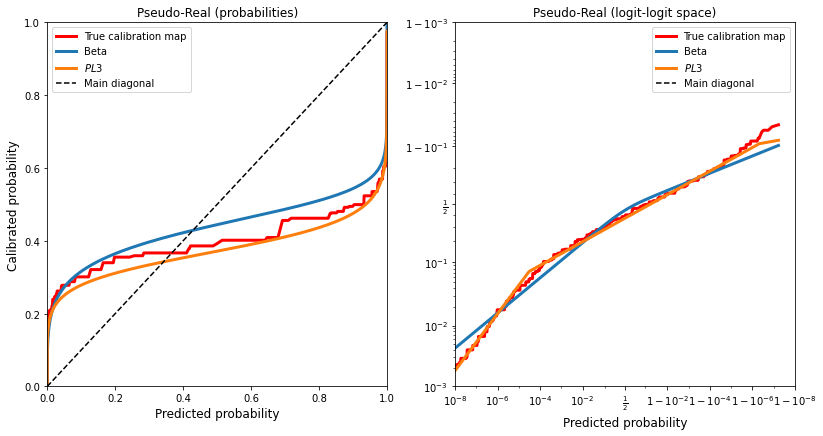

In [301]:
fig, ax = plt.subplots(figsize=(6.7*2,6.7), nrows=1, ncols=2)

x_range = np.arange(0.0, 1.001, 0.001)

# CF
ax[0].plot(df2.iloc[:, 0], df2.iloc[:, 1], c="red", label="True calibration map", zorder=1, lw=3)

# BC
ax[0].plot(df3.iloc[:, 0], df3.iloc[:, 1], label="Beta", zorder=1, lw=3)
#plt.plot(df3.iloc[:, 0], df3.iloc[:, 2], label="TempS", zorder=1, lw=3)
#plt.plot(df3.iloc[:, 0], df3.iloc[:, 3], label="$PL_{neuro}$", zorder=1, lw=3)
ax[0].plot(df3.iloc[:, 0], df3.iloc[:, 4], label="$PL3$", zorder=1, lw=3)

# DIAGONAL
ax[0].plot([0,1], [0,1], "--", c="black", label="Main diagonal", zorder=2)

ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("Predicted probability", fontsize=12)
ax[0].set_ylabel("Calibrated probability", fontsize=12)
ax[0].set_title("Pseudo-Real (probabilities)")
ax[0].legend()#loc=(0.04, 0.76)


x_range = np.arange(0.0001, 1.000, 0.001)

# CF
ax[1].plot(df2.iloc[:, 0], df2.iloc[:, 1], c="red", label="True calibration map", zorder=1, lw=3)

# BC
#plt.plot(x_range, bc.predict(x_range), label="Beta", zorder=1, lw=3)
#plt.plot(x_range, TempS.predict(clip_logit([1-x_range, x_range]).T)[:,1], label="TempS", zorder=1, lw=3)
#plt.plot(df3.iloc[:, 0], df3.iloc[:, 3], label="$PL_{neuro}$", zorder=1, lw=3)
#plt.plot(x_range, pw6.predict(x_range), label="$PL_{logit}$", zorder=1, lw=3)

ax[1].plot(df3.iloc[:, 0], df3.iloc[:, 1], label="Beta", zorder=1, lw=3)
#plt.plot(df3.iloc[:, 0], df3.iloc[:, 2], label="TempS", zorder=1, lw=3)
#plt.plot(df3.iloc[:, 0], df3.iloc[:, 3], label="$PL_{neuro}$", zorder=1, lw=3)
ax[1].plot(df3.iloc[:, 0], df3.iloc[:, 4], label="$PL3$", zorder=1, lw=3)

# DIAGONAL
ax[1].plot([0,1], [0,1], "--", c="black", label="Main diagonal", zorder=2)

eps = 1e-8
ax[1].set_xlim(eps,1 - eps)
ax[1].set_ylim(1e-3,1 - 1e-3)
ax[1].set_xlabel("Predicted probability", fontsize=12)
#ax[1].set_ylabel("Calibrated probability", fontsize=12)
ax[1].set_xscale("logit")
ax[1].set_yscale("logit")
ax[1].set_title("Pseudo-Real (logit-logit space)")
ax[1].legend()#loc=(0.04, 0.76)
plt.savefig("fig/fig_pseudo_real_probs_logits.pdf", dpi=250, bbox_inches="tight")
#plt.xlabel("Test")
plt.show()
    